# A pedagogical example of fine-mapping problem

Here we demonstrate with simulated data a setting that for fine-mapping problem it is problematic to run step-wise conditional analysis, but SuSiE's variational procedure can correctly identify the causal signals.

In [1]:
%revisions -s --tags --no-walk

In [2]:
library(susieR)
set.seed(1)

In [3]:
dat = readRDS(system.file("data", "N2finemapping.rds", package = "susieR"))
names(dat)

[1] "X"                 "chrom"             "pos"              
[4] "true_coef"         "residual_variance" "Y"                
[7] "allele_freq"       "V"

This simulated data-set has two replicates. We focus on the fist replicate:

In [4]:
r = 1

## Comparing SuSiE with per-variable regression

We fit SuSiE and obtain its CS and PIP: 

In [5]:
fitted = susie(dat$X, dat$Y[,r], L=5,
               estimate_residual_variance=TRUE, 
               prior_variance=0.2,
               tol=1e-3, track_fit=TRUE)
sets = susie_get_CS(fitted,
            coverage = 0.95,
            X = dat$X, 
            min_abs_corr = 0.1)
pip = susie_get_PIP(fitted, sets$cs_index)

We also perform a per-feature simple regression and get (asymptotic) z-scores from it:

In [6]:
z_score = susieR:::calc_z(dat$X, dat$Y[,r])

We plot p-values from per-feature regression in parallel with PIP from SuSiE. 

In [9]:
b = dat$true_coef[,r]
b[which(b!=0)] = 1
png('demo.png', 12, 6, units = 'in', res = 500)
par(mfrow=c(1,2))
susie_pplot(z_score, dtype='z', b=b, main = 'Per-feature regression p-values')
susie_pplot(pip, res=fitted, CS=sets, dtype='PIP', b=b, max_cs=0.4, main = paste('SuSiE', length(sets$cs), 'CS identified'))
dev.off()

png 
  2

> demo.png (207.6 KiB):

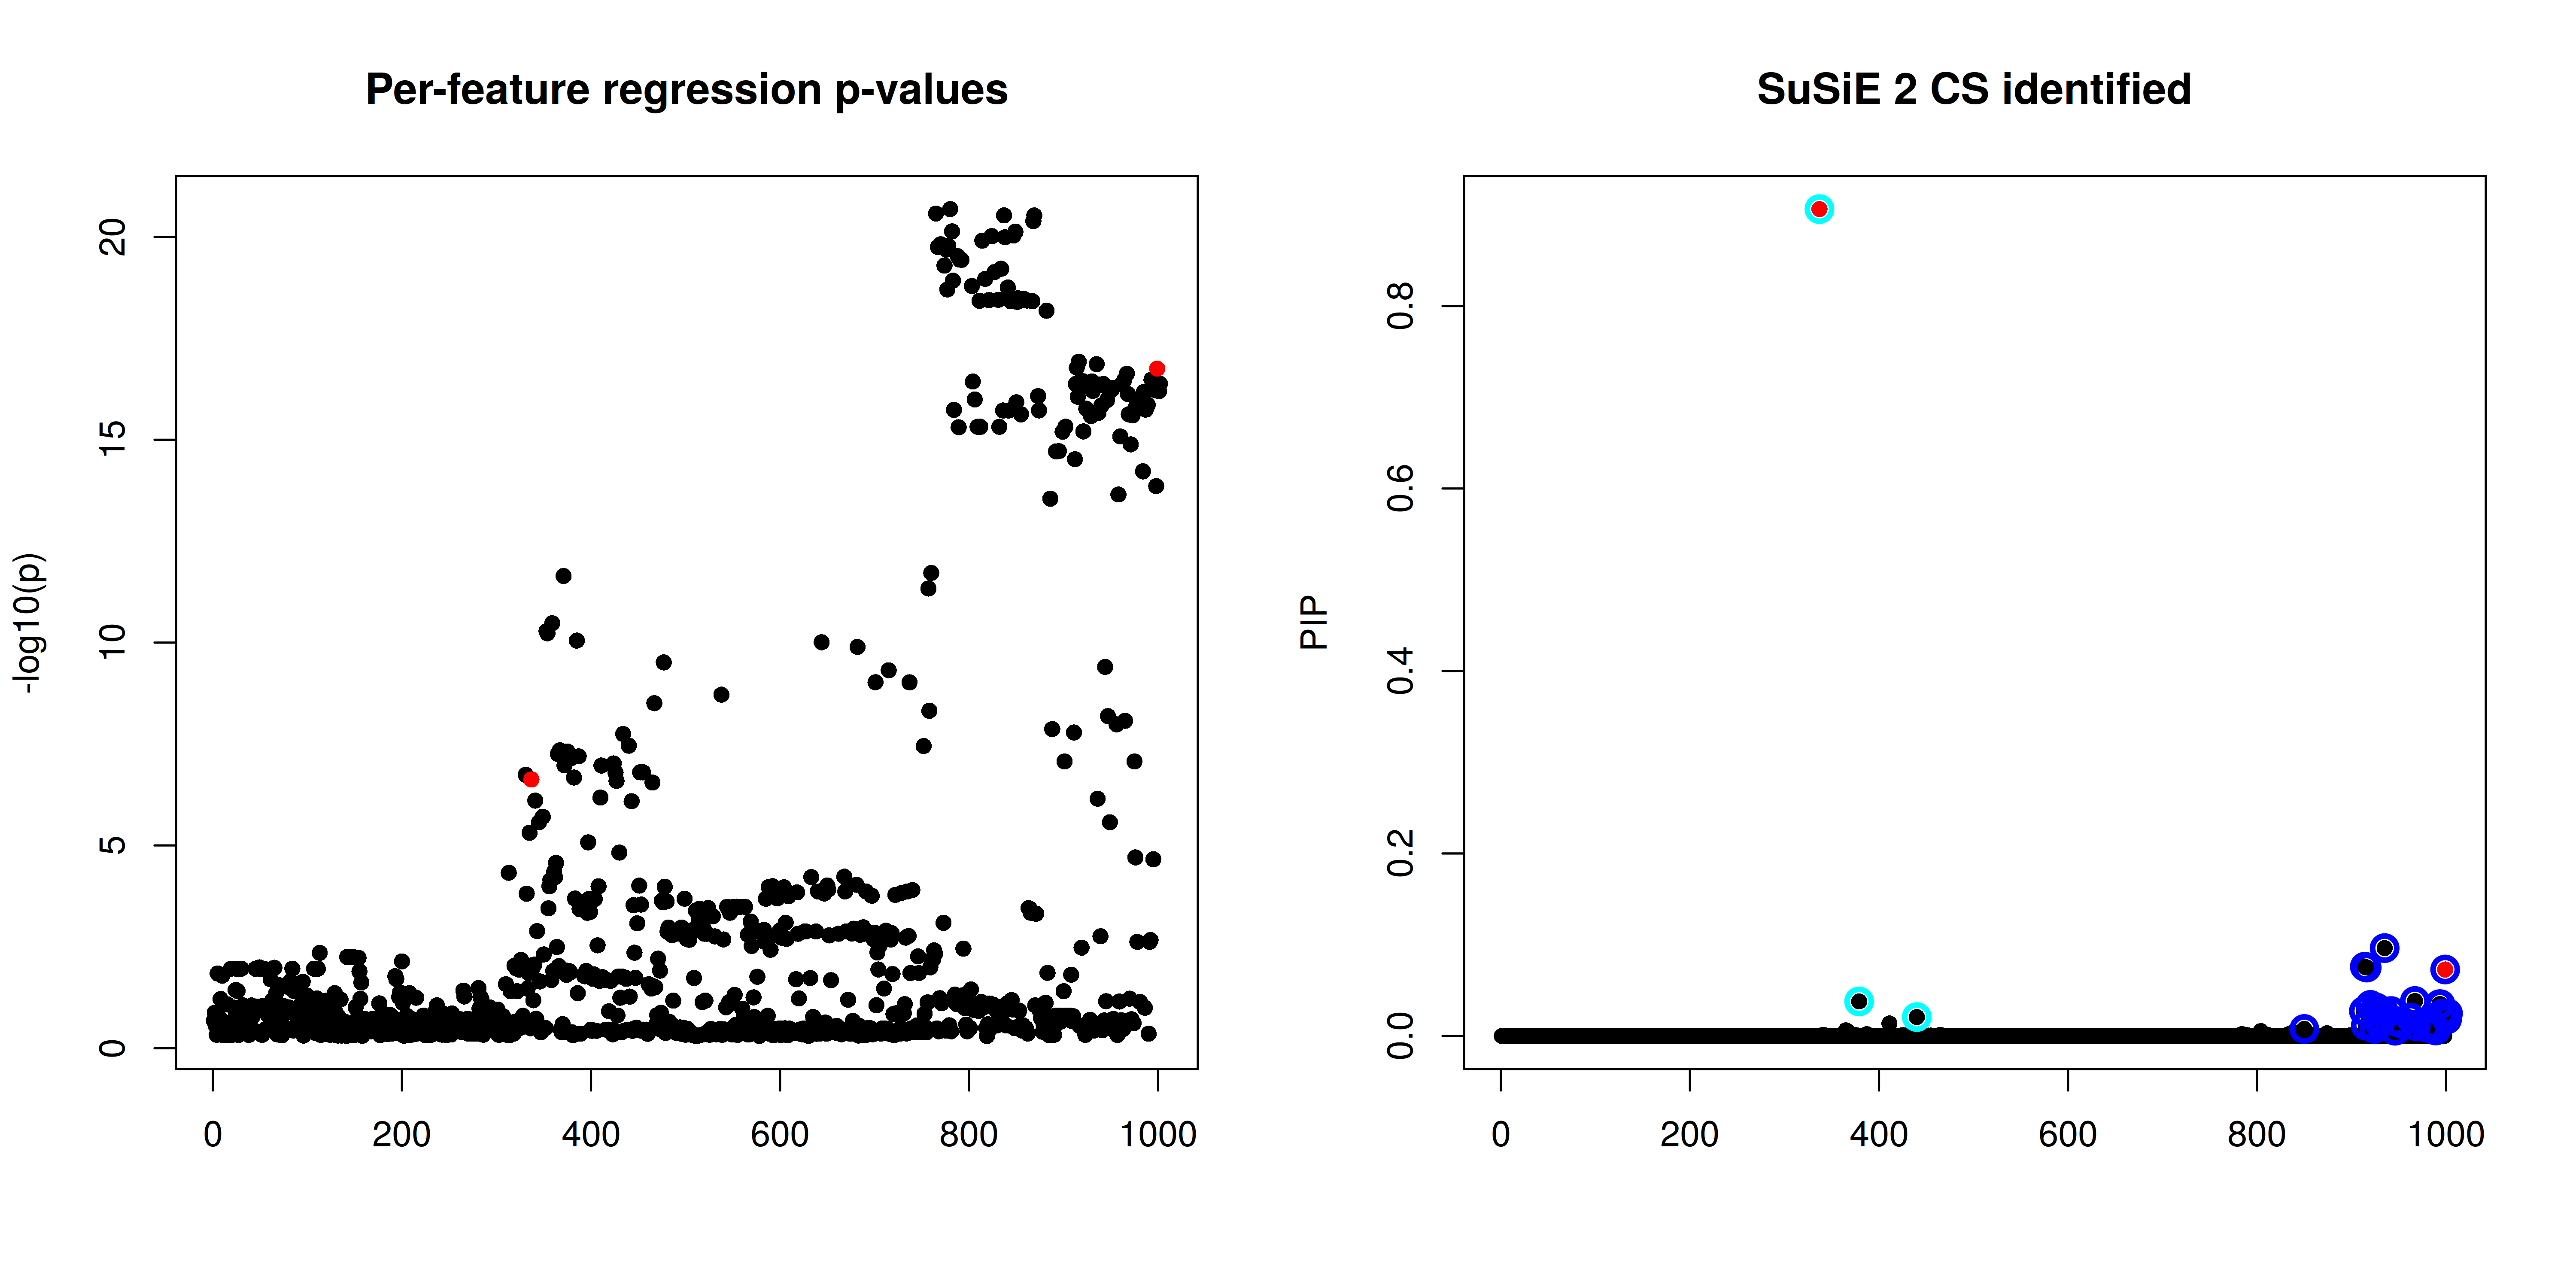

In [10]:
%preview demo.png

The identified CS are:

In [8]:
print(sets$cs)

$L2
 [1]  850  913  914  915  916  920  924  925  926  927  930  931  933  934  935
[16]  942  946  948  951  952  962  967  968  979  980  982  983  985  988  989
[31]  993  994  996  999 1000 1001 1002

$L3
[1] 337 379 440



`L2` corresponds to the blue cluster around position 900. `L3` corresponds to the cyan cluster around position 400. In both cases the simulated non-zero effect are captured by the confidence sets.

The CS `L2` has many variables. We check how correlated they are:

In [9]:
sets$purity

,min.abs.corr,mean.abs.corr,median.abs.corr
L2,0.9722386,0.9939738,0.9949722
L3,0.8534981,0.9183993,0.8944609


The minimum absolute correlation is 0.97 for CS `L2`. So SuSiE behavior is reasonable.

## Looking into SuSiE VEM iterations

It takes 23 iterations for SuSiE to converge on this example. With `track_fit=TRUE` we keep in `fitted$trace` object various quantities to help with diagnotics.

In [10]:
fitted$niter

[1] 23

In [11]:
susie_iterplot(fitted, 3, 'demo')

Creating GIF animation ...
Iterplot saved to demo.gif


> demo.gif (211.3 KiB):

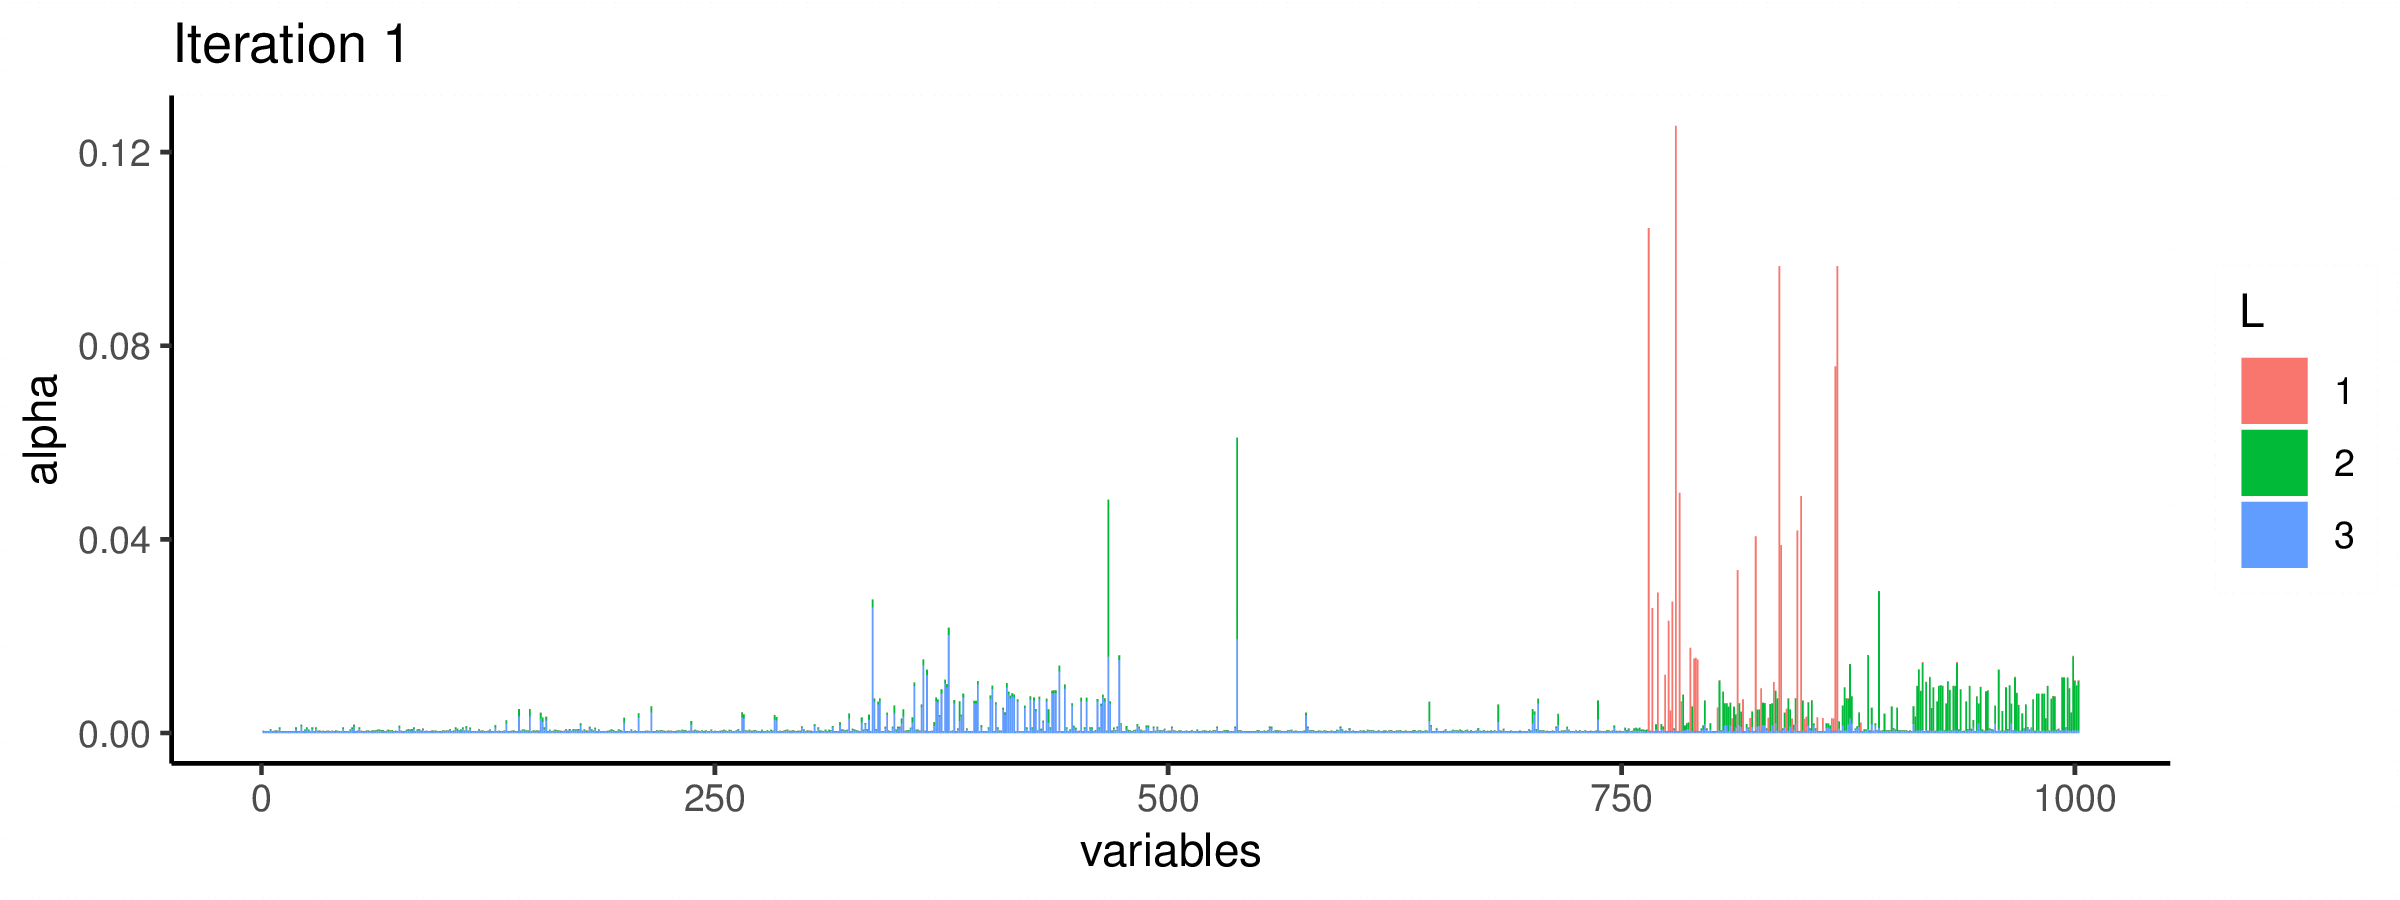

In [12]:
%preview demo.gif

At the first iteration, the variable with the top z-score was picked up by the first CS. But in later iterations, the first CS vanishes; the 2nd and 3rd CS correctly pick up the two "true" signals.

## SuSiE with `L=2`

We now set `L=2` and see how SuSiE converges to the true signals, if capable:

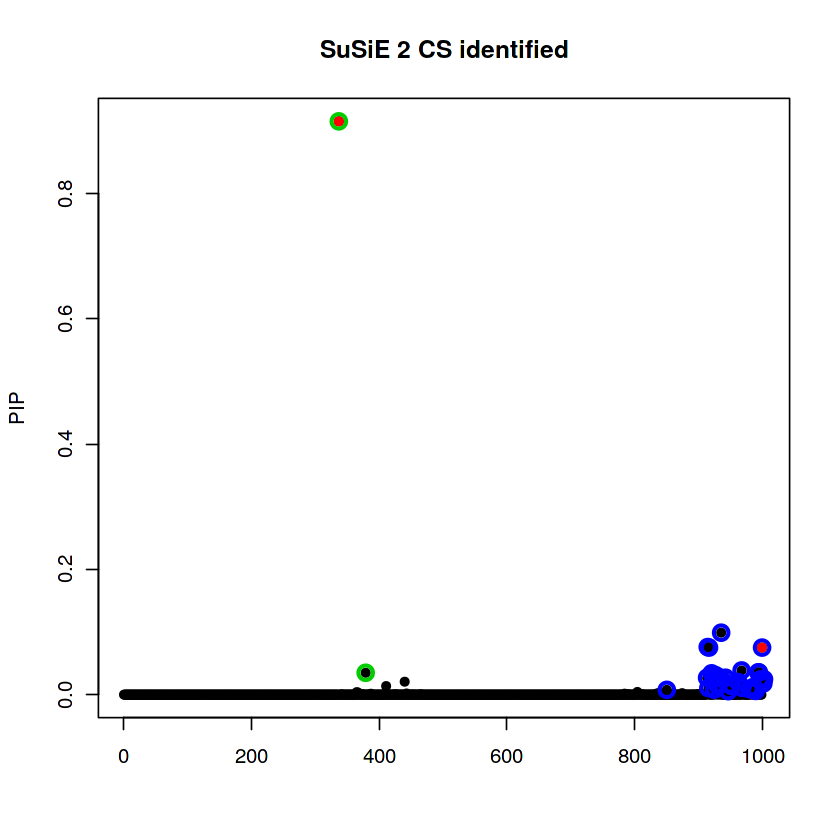

In [8]:
fitted = susie(dat$X, dat$Y[,r], L=2,
               estimate_residual_variance=TRUE, 
               prior_variance=0.2,
               tol=1e-3, track_fit=TRUE)
sets = susie_get_CS(fitted,
            coverage = 0.95,
            X = dat$X, 
            min_abs_corr = 0.1)
pip = susie_get_PIP(fitted, sets$cs_index)
susie_pplot(pip, res=fitted, CS=sets, dtype='PIP', b=b, max_cs=0.4, main = paste('SuSiE', length(sets$cs), 'CS identified'))

In [9]:
fitted$niter

[1] 10

In [10]:
susie_iterplot(fitted, 2, 'demo_l2')

Creating GIF animation ...
Iterplot saved to demo_l2.gif


> demo_l2.gif (156.5 KiB):

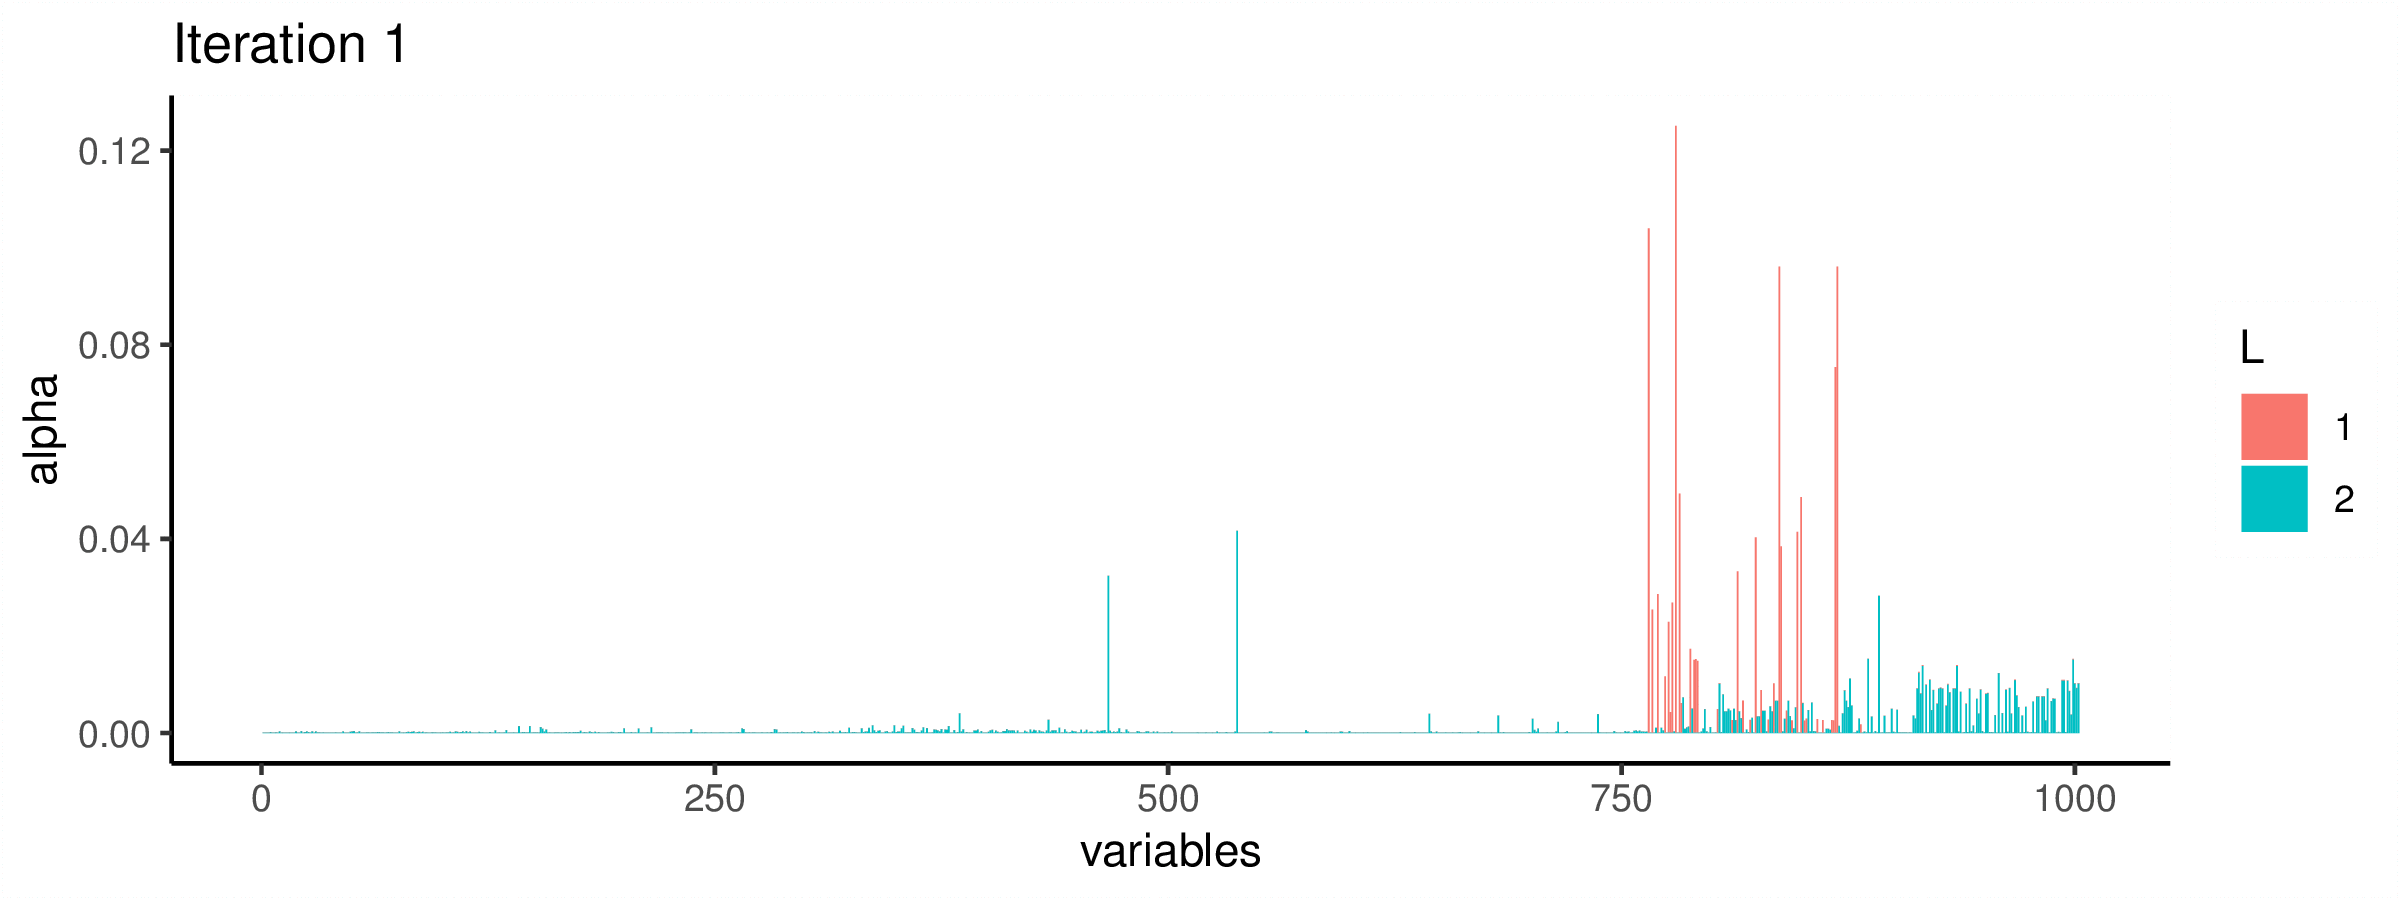

In [11]:
%preview demo_l2.gif

It seems at the first iteration, the first CS picks up the induced wrong signal cluster, but the true signal were both picked up by the 2nd CS which is quite wide. Later iterations removed the induced wrong cluster and the 2 CS properly converged to the two true signals as desired.

## Is the result robust to prior choice?
Here instead of fixing prior, I ask SuSiE to update prior variance

In [11]:
fitted = susie(dat$X, dat$Y[,r], L=5,
               estimate_residual_variance=TRUE, 
               estimate_prior_variance=TRUE,
               tol=1e-3, track_fit=TRUE)
sets = susie_get_CS(fitted,
            coverage = 0.95,
            X = dat$X, 
            min_abs_corr = 0.1)
pip = susie_get_PIP(fitted, sets$cs_index)

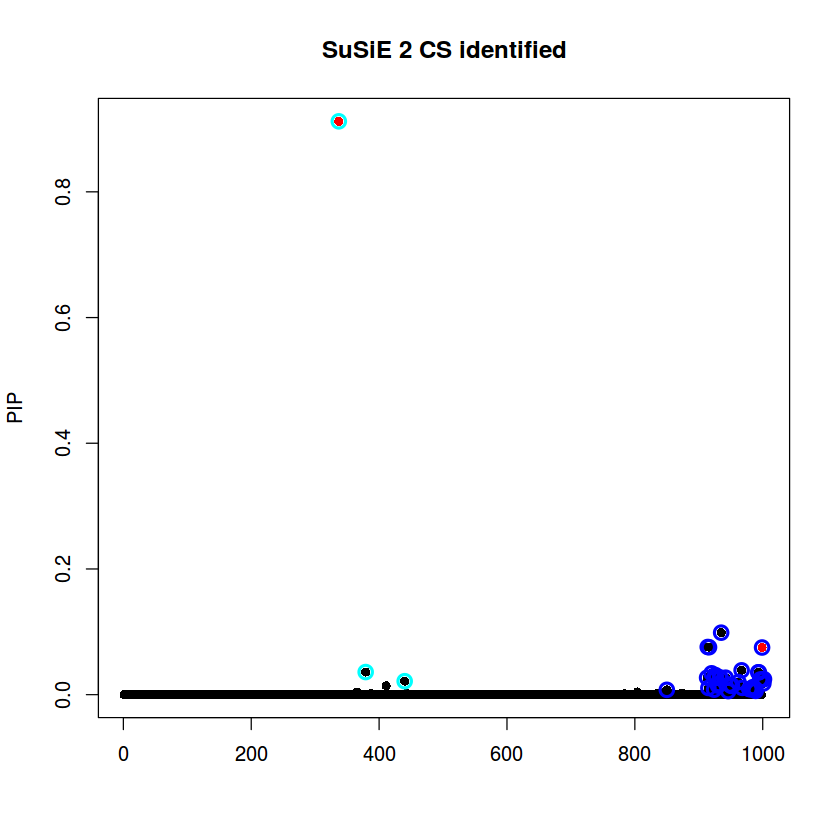

In [13]:
susie_pplot(pip, res=fitted, CS=sets, dtype='PIP', b=b, max_cs=0.4, main = paste('SuSiE', length(sets$cs), 'CS identified'))

Result remains largely the same.

## How other methods cope with this situation?

In [this folder](https://github.com/stephenslab/susieR/tree/master/inst/code) we provide scripts to run `CAVIAR`, `FINEMAP` (version 1.1) and `DAP-G` on the same data-set for a comparison. We generate summary statistics and run these 3 other methods on the example.

In [13]:
library(abind)
mm_regression = function(X, Y, Z=NULL) {
  if (!is.null(Z)) {
      Z = as.matrix(Z)
  }
  reg = lapply(seq_len(ncol(Y)), function (i) simplify2array(susieR:::univariate_regression(X, Y[,i], Z)))
  reg = do.call(abind, c(reg, list(along=0)))
  # return array: out[1,,] is betahat, out[2,,] is shat
  return(aperm(reg, c(3,2,1)))
}
sumstats = mm_regression(as.matrix(dat$X), as.matrix(dat$Y))
saveRDS(list(data=dat, sumstats=sumstats), 'N2.with_sumstats.rds')

In [14]:
%cd ~/tmp

/home/gaow/tmp

In [15]:
export PATH=~/GIT/github/mvarbvs/dsc/modules/linux:$PATH
Rscript ~/GIT/software/susieR/inst/code/finemap.R input=\"N2.with_sumstats.rds\" output=\"N2finemapping.FINEMAP\" args=\"--n-causal-max\ 2\"


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

Running shell command:
finemap --sss --log --in-files /tmp/RtmpEWIOaQ/file1d982138b2f7.finemap_condition_1.master --n-causal-max 2

|---------------------------------|
| Welcome to FINEMAP v1.1         |
|                                 |
| (c) 2015 University of Helsinki |
|                                 |
| Help / Documentation:           |
| - ./finemap --help              |
| - www.christianbenner.com       |
|                                 |
| Contact:                        |
| - christian.benner@helsinki.fi  |
| - matti.pirinen@helsinki.fi     |
|---------------------------------|

--------
SETTINGS
--------
- regions         : 1 
- n-causal-max    : 2
- n-configs-top   : 50000
- n-iterations    : 100000
- n-convergence   : 1000
- prob-tol        : 0.001
- corr-config     : 0.95


In [16]:
export PATH=~/GIT/github/mvarbvs/dsc/modules/linux:$PATH
Rscript ~/GIT/software/susieR/inst/code/caviar.R input=\"N2.with_sumstats.rds\" output=\"N2finemapping.CAVIAR\" args=\"-c\ 2\"


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

Running shell command:
CAVIAR -z /tmp/RtmpNkNPL4/file1dcf216e1f74.caviar_condition_2.z -l /tmp/RtmpNkNPL4/file1db71315efc4.ld -o /tmp/RtmpNkNPL4/file1dcf216e1f74.caviar_condition_2 -c 2
@-------------------------------------------------------------@
| CAVIAR!		| 	   v2.2         |  10/Apr/2018| 
|-------------------------------------------------------------|
| (C) 2018 Farhad Hormozdiari, GNU General Public License, v2 |
|-------------------------------------------------------------|
| For documentation, citation & bug-report instructions:      |
| 		http://genetics.cs.ucla.edu/caviar/           |
@-------------------------------------------------------------@
Running shell command:
CAVIAR -z /tmp/RtmpNkNPL4/file1dce216e1f74.caviar_condition_1.z -l /tmp/RtmpNkNPL4/file1db71315efc4.ld -o /tmp

In [17]:
export PATH=~/GIT/github/mvarbvs/dsc/modules/linux:$PATH
python ~/GIT/software/susieR/inst/code/dap-g.py N2.with_sumstats.rds N2finemapping.DAP -ld_control 0.20 --all

Now we look at these results.

In [18]:
caviar = readRDS("N2finemapping.CAVIAR.rds")
finemap = readRDS("N2finemapping.FINEMAP.rds")
dap = readRDS("N2finemapping.DAP.rds")

### `CAVIAR` results

#### PIP

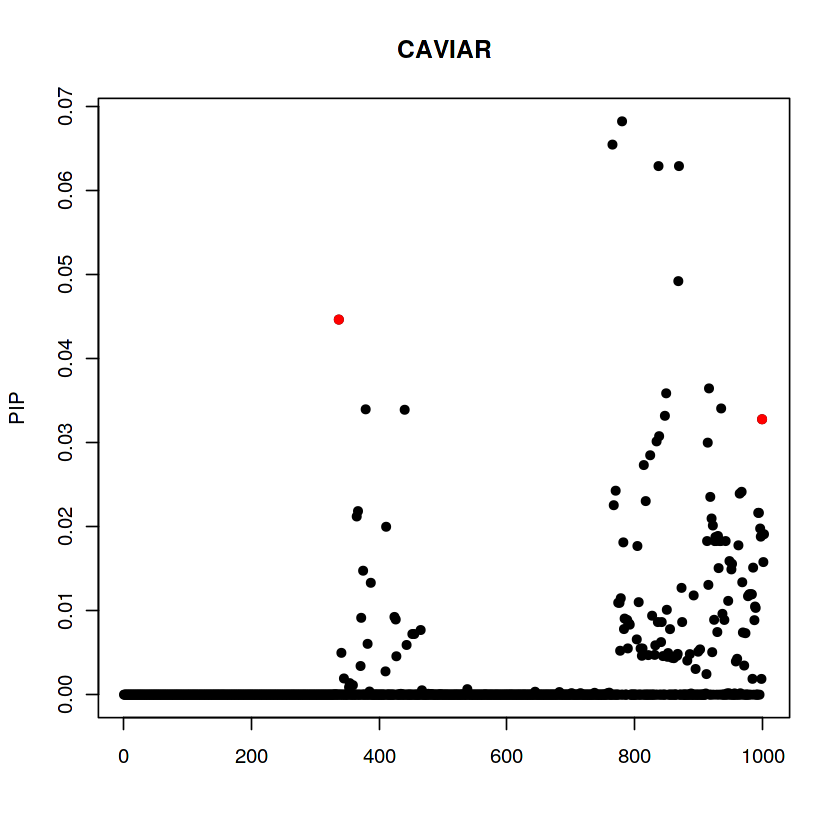

In [19]:
snp = caviar[[1]]$snp
pip = snp[order(as.numeric(snp$snp)),]$snp_prob
susie_pplot(pip, dtype='PIP', b=b, main = 'CAVIAR')

#### 95% CS

CAVIAR provides single 95% confidence sets as follows:

In [20]:
print(caviar[[1]]$set)

  [1] "780"  "765"  "837"  "869"  "868"  "337"  "916"  "849"  "935"  "379" 
 [11] "440"  "847"  "999"  "838"  "834"  "914"  "824"  "814"  "770"  "967" 
 [21] "964"  "918"  "817"  "767"  "367"  "993"  "994"  "365"  "920"  "922" 
 [31] "411"  "996"  "1000" "1002" "930"  "997"  "926"  "913"  "925"  "927" 
 [41] "933"  "934"  "942"  "782"  "962"  "804"  "948"  "1001" "952"  "985" 
 [51] "931"  "951"  "375"  "968"  "387"  "915"  "873"  "979"  "980"  "982" 
 [61] "983"  "892"  "977"  "778"  "946"  "806"  "774"  "776"  "988"  "989" 
 [71] "850"  "937"  "827"  "424"  "372"  "784"  "426"  "924"  "940"  "788" 
 [81] "987"  "836"  "842"  "874"  "791"  "790"  "792"  "783"  "855"  "465" 
 [91] "929"  "969"  "973"  "452"  "455"  "803"  "841"  "382"  "443"  "832" 
[101] "789"  "809"  "812"  "902"  "777"  "899"  "921"  "341" 


In [21]:
any(which(b>0) %in% caviar[[1]]$set)

[1] TRUE

It is a wide CS, although it does capture the causal SNPs. 

### `FINEMAP` results

#### PIP

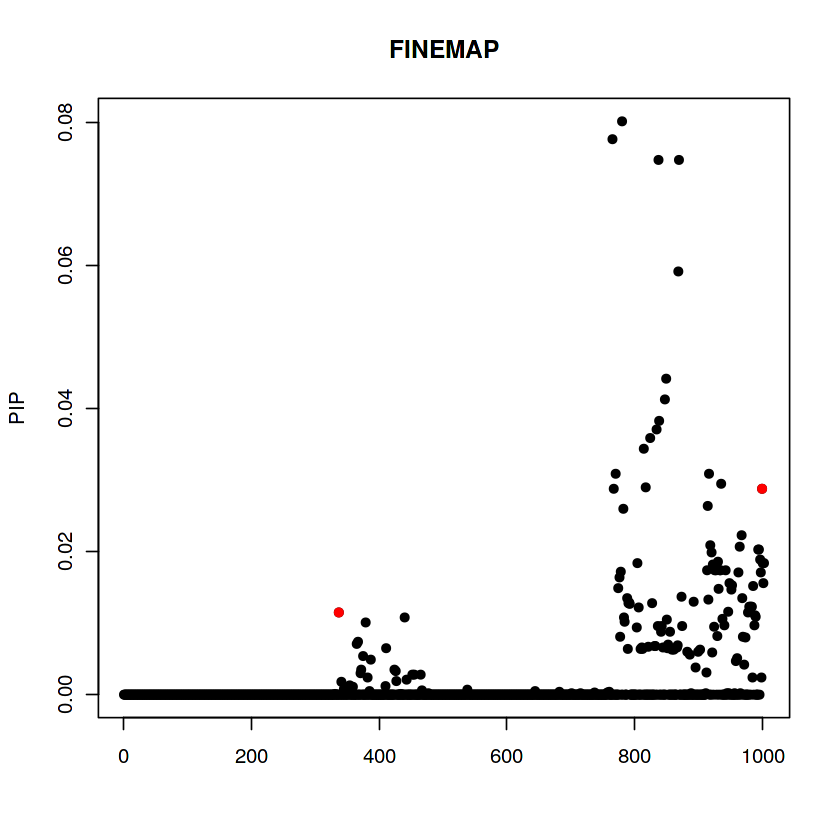

In [22]:
snp = finemap[[1]]$snp
pip = snp[order(as.numeric(snp$snp)),]$snp_prob
susie_pplot(pip, dtype='PIP', b=b, main = 'FINEMAP')

#### 95% CS

For each configuration, FINEMAP provides the corresponding configuration probability:

In [23]:
head(finemap[[1]]$set, 10)

rank,config,config_prob,config_log10bf,config_prob_cumsum
1,"780,916",0.002430376,15.22015,0.002430376
2,"780,935",0.002337337,15.20320,0.004767713
3,"780,999",0.002332030,15.20221,0.007099743
4,"765,999",0.002209795,15.17883,0.009309538
5,"765,935",0.002208498,15.17858,0.011518036
6,"765,916",0.002171861,15.17131,0.013689896
7,"837,999",0.002134201,15.16371,0.015824097
8,"869,999",0.002134201,15.16371,0.017958298
9,"837,935",0.002133318,15.16353,0.020091615
10,"869,935",0.002133318,15.16353,0.022224933


It requires post-processing to come up with a single 95% set similar to that of CAVIAR with all 3 causal variables captured. The result from running `finemap.R` provided has been truncated to the minimum set of configurations having cumulative probability of 95%. But the top 10 configurations completely missed the causal signals.

### `DAP-G` results

#### PIP

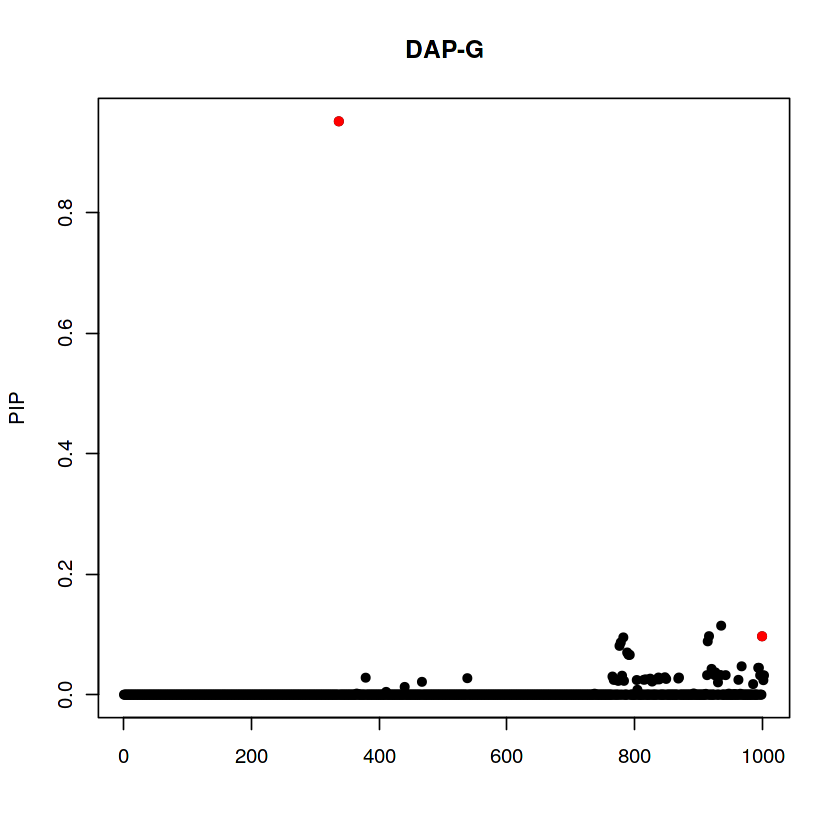

In [24]:
snp = dap[[1]]$snp
pip = snp[order(as.numeric(snp$snp)),]$snp_prob
susie_pplot(pip, dtype='PIP', b=b, main = 'DAP-G')

Good job!

#### 95% CS

Similar to SuSiE, DAP-G provides per-signal 95% CS:

In [25]:
dap[[1]]$set

,cluster,cluster_prob,cluster_avg_r2,snp
0,1,1.000000,0.855,"782,778,776,788,790,791,792,780,765,847,869,837,868,824,849,817,838,834,770,814,767,803,783,774,827"
1,2,1.000000,0.966,"935,916,999,914,967,993,994,920,926,925,913,927,933,934,942,996,1002,1000,962,1001,930,985,804,892"
2,3,1.000000,0.821,"337,379,440,411,365,367"
3,4,0.055970,0.558,"538,467,947,737,965,911,956"
4,5,0.000072,1.000,157


Using an average $r^2$ filter of 0.2 ($r=0.44$, compared to SuSiE's $r=0.1$ in earlier analysis), it reports five 95% CS; the first 3 CS contain causal signals. Also the first CS is wider.